In [1]:
import sys ###nstep_sarsa1（ここから[2]の11行目までと、[2]の20行目以降）
sys.path.append('./scripts/')
from sarsa import *

In [2]:
class NstepSarsaAgent(SarsaAgent): 
    def __init__(self, time_interval, estimator, puddle_coef=100,  alpha=0.5, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8], nstep=10): #nstepを追加
        super().__init__(time_interval, estimator, puddle_coef,  alpha, widths, lowerleft, upperright, dev_borders)
        
        self.s_trace = [] #以下追加
        self.a_trace = []
        self.r_trace = []
        self.nstep = nstep
        
    def decision(self, observation=None):
        ##終了処理##
        if self.update_end:  return 0.0, 0.0
        if self.in_goal:          self.update_end = True
        
        ##カルマンフィルタの実行##
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(observation)
        
        ##行動決定と報酬の処理##
        s_, a_ = self.policy(self.estimator.pose)
        r = self.time_interval*self.reward_per_sec() 
        self.r_trace.append(r) #インデックスの整合性のためにrは先に登録しておく
        self.total_reward += r
        
        ##Q値の更新とs', a'の記録##
        self.q_update(s_, a_, self.nstep)
        self.s_trace.append(s_)
        self.a_trace.append(a_)

        ##出力##
        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.actions[a_]

    def q_update(self, s_, a_, n):
        if n > len(self.s_trace) or n == 0: return
        
        s, a = self.s_trace[-n], self.a_trace[-n] #更新対象の状態行動対
        
        q = self.ss[s].q[a]                                      #更新前のQ値
        r = sum(self.r_trace[-n:])                         #nステップ前までの報酬の和
        q_ = self.final_value if self.in_goal else self.ss[s_].q[a_] #遷移後のQ値
        self.ss[s].q[a] = (1.0 - self.alpha)*q + self.alpha*(r + q_) #更新
                
        if self.in_goal: #ゴールしたら1〜n-1ステップ前のQ値を更新
            self.q_update(s_, a_, n-1)

<IPython.core.display.Javascript object>


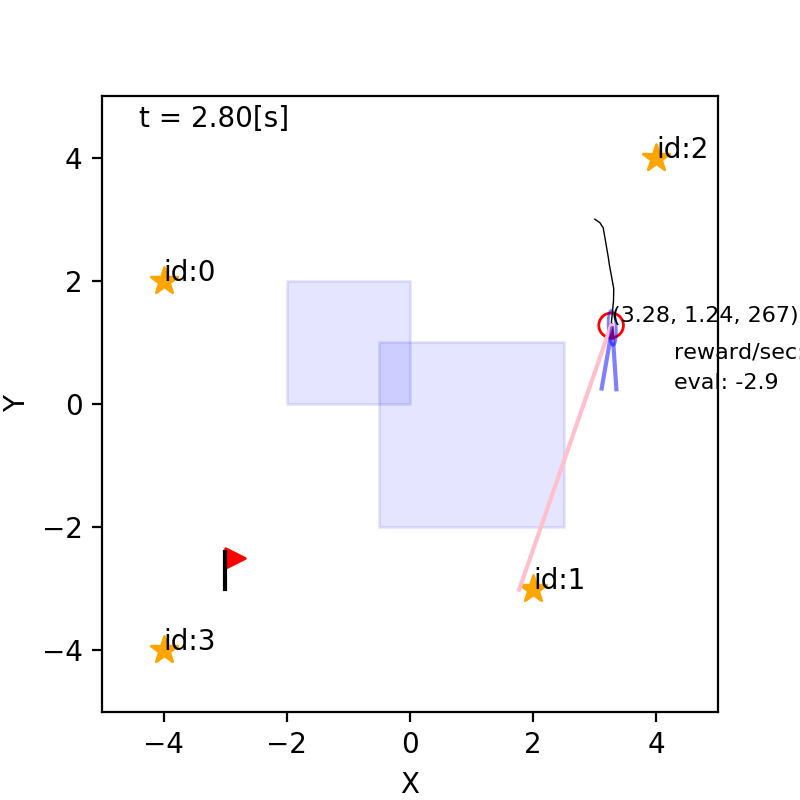

In [3]:
def trial(): 
    time_interval = 0.1
    world = PuddleWorld(400000, time_interval, debug=False)  #長時間アニメーション時間をとる

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3) 
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##ロボットを1台登場させる##
    init_pose = np.array([3, 3, 0]).T
    kf = KalmanFilter(m, init_pose)
    a = NstepSarsaAgent(time_interval, kf)
    r = WarpRobot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))
    world.append(r)
    
    world.draw()
    return a
    
a = trial()